# Data Mining

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from scipy import stats
%matplotlib inline
%autosave 300
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import scale, Normalizer, normalize, scale, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from IPython.display import display, HTML

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 16
plt.rcParams["figure.facecolor"] = 'white'

import matplotlib
params = {'axes.labelsize': 18,'axes.titlesize':20, 'legend.fontsize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
matplotlib.rcParams.update(params)
np.set_printoptions(precision=4)

from sklearn.model_selection import KFold
num_splits = 5.0
kf = KFold(n_splits=int(num_splits))

raw_data = pd.read_csv('data/fighter_data.csv')

Autosaving every 300 seconds


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Preprocessing

In [2]:
df_5w = raw_data[((raw_data['w'].astype(int)+raw_data['l'].astype(float)+raw_data['d'].astype(float)) >= 5)]
significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]

In [3]:
def extract_stats_df(input_df):
    df = input_df.filter(['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 
                                     'TD Acc.', 'TD Def.', 'Sub. Avg.'], 
                                     axis=1)
    df['Str. Acc.'] = df['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['Str. Def'] = df['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Acc.'] = df['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Def.'] = df['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
    return df
stats_df = extract_stats_df(significant_df)

In [4]:
xticks = ['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 'TD Acc.', 'TD Def.', 'Sub. Avg.']

In [5]:
#load the current top15 ranked fighters in all divisions
top15_all_class = np.genfromtxt('./data/top15.csv', delimiter=',', dtype='str')

significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]

top15_df = significant_df[(significant_df['first'] + ' ' + significant_df['last']).isin(top15_all_class)]

In [6]:
top15_names_df = (top15_df['first'] + ' ' + top15_df['last']).values

In [8]:
reach_op = lambda x: float(x.replace('"', '').strip())
weight_op = lambda x: float(x.split()[0])
stracc_op = lambda x: float(x[:-1])

In [9]:
def height_op(in_str):
    in_str = str(in_str)
    if type(in_str) is int:
        return in_str
    feet, inches = in_str.split(' ')
    feet_num = int(feet[:-1])
    inches_num = int(inches[:-1])
    return feet_num * 12 + inches_num

In [10]:
def result_op(in_str):
    if 'win' in in_str:
        return 1
    elif 'loss' in in_str:
        return 0
    elif 'n/a' in in_str:
        return 0

In [7]:
def cleanup_df(indf):
    ret = pd.DataFrame()
    indf.dropna(subset=['height', 'reach'], inplace=True)
    ret['reach'] = indf['reach'].apply(reach_op)
    ret['weight'] = indf['weight'].apply(weight_op)
    ret['height'] = indf['height'].apply(height_op)
    ret['w/l'] = indf['w']/(indf['w']+indf['l'])
    ret['SLpM'] = indf['SLpM']
    ret['Str. Acc.'] = indf['Str. Acc.'].apply(stracc_op)
    ret['SApM'] = indf['SApM'].apply(float)
    ret['Str. Def'] = indf['Str. Def'].apply(stracc_op)
    ret['TD Avg'] = indf['TD Avg'].apply(float)
    ret['TD Acc.'] = indf['TD Acc.'].apply(stracc_op)
    ret['TD Def.'] = indf['TD Def.'].apply(stracc_op)
    ret['Sub. Avg.'] = indf['Sub. Avg.'].apply(float)
    ret['result'] = indf['result'].apply(result_op)
    return ret

In [12]:
#create new vector consisting of: height, weight, reach, w/l ratio, and statistics
def generate_delta(primary, contender, mode='absolute'):
    #first cleanup input dataframes
    primary_clean = cleanup_df(primary)
    contender_clean = cleanup_df(contender)
    if mode == 'absolute':
        delta = pd.DataFrame(data = (contender_clean.values-primary_clean.values),
                             columns=contender_clean.columns)
    elif mode == 'percentage':
        delta = pd.DataFrame(100*(contender_clean.values-primary_clean.values)/primary_clean.values,
                             columns=contender_clean.columns)
    return delta

# Top15 Fighters

In [15]:
df_top15 = pd.read_csv('./data/top15_results.csv', delimiter=',', header=None)
df_top15.columns = ['red', 'blue', 'result']
df_top15['red_first'] = df_top15['red'].str.split(' ', expand=True)[0]
def get_last_name(x):
    return x.split(' ')[-1]
df_top15['red_last'] = df_top15['red'].apply(get_last_name)
df_top15['blue_first'] = df_top15['blue'].str.split(' ', expand=True)[0]
df_top15['blue_last'] = df_top15['blue'].apply(get_last_name)

In [16]:
top15_list = df_top15['red'].unique()
df_top15.head()

,red,blue,result,red_first,red_last,blue_first,blue_last
0,Demetrious Johnson,Wilson Reis,win,Demetrious,Johnson,Wilson,Reis
1,Demetrious Johnson,Tim Elliott,win,Demetrious,Johnson,Tim,Elliott
2,Demetrious Johnson,Henry Cejudo,win,Demetrious,Johnson,Henry,Cejudo
3,Demetrious Johnson,John Dodson,win,Demetrious,Johnson,John,Dodson
4,Demetrious Johnson,Kyoji Horiguchi,win,Demetrious,Johnson,Kyoji,Horiguchi


In [17]:
'''
To generate deltas, loop through the top fighters one by one and concatenate deltas results
'''
frames = []
for fighter in top15_list:
    try:
        df_fighter = df_top15[df_top15['red'] == fighter]
        first = df_fighter['red_first'].values[0]
        last = df_fighter['red_last'].values[0]
        fighter_stats = df_5w[(df_5w['first'] == first) & (df_5w['last'] == last)]
        fighter_stats.isnull().values.any()
        fighter_stats['result'] = 'n/a'
        opponent_stats = pd.merge(df_5w, df_fighter, left_on=['first', 'last'], right_on=['blue_first', 'blue_last'], how='inner')
        fighter_deltas = generate_delta(fighter_stats, opponent_stats)
        frames.append(fighter_deltas)
    except:
        print first, last
#         display(fighter_stats)
#         display(opponent_stats)
# fighter_deltas.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Brandon Moreno
Chan Jung
Rafael Anjos
Dong Kim
David Branch
Volkan Oezdemir
Ovince Preux
Cynthia Calvillo
Germaine Randamie
Ketlen Vieira


In [18]:
df_deltas_top15 = pd.concat(frames)
df_deltas_top15.replace([np.inf, -np.inf], np.nan, inplace=True)
#Need to figure out why there are NAN results
df_deltas_top15.dropna(inplace=True)

In [19]:
train_predictors = df_deltas_top15.iloc[:,:-1]
train_response = df_deltas_top15['result']
X = train_predictors.values
y = train_response.values

In [20]:
print X.shape
print y.shape

(1525, 12)
(1525,)


In [139]:
percent_misclassified = 0
# train_predictors_norm = scale(train_predictors_norm)
X_norm = scale(X)
for train_index, test_index in kf.split(X_norm):
    x_train, x_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = DummyClassifier(strategy='most_frequent',random_state=0)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.89


In [140]:
percent_misclassified = 0
# train_predictors_norm = scale(train_predictors_norm)
X_norm = scale(X)
for train_index, test_index in kf.split(X_norm):
    x_train, x_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = AdaBoostClassifier(n_estimators=100)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.10


In [141]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = linear_model.LogisticRegression()
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 27.67


In [142]:
percent_misclassified = 0

for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    neigh = KNeighborsClassifier(n_neighbors=151, n_jobs=-1)
    y_pred = neigh.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.82


In [21]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_jobs=-1, max_features=5, n_estimators=500)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
#     print("mislabeled out of %d obs : %0.2f"% (x_test.shape[0], 100*(y_test != y_pred).sum()/float(x_test.shape[0])))
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 27.28


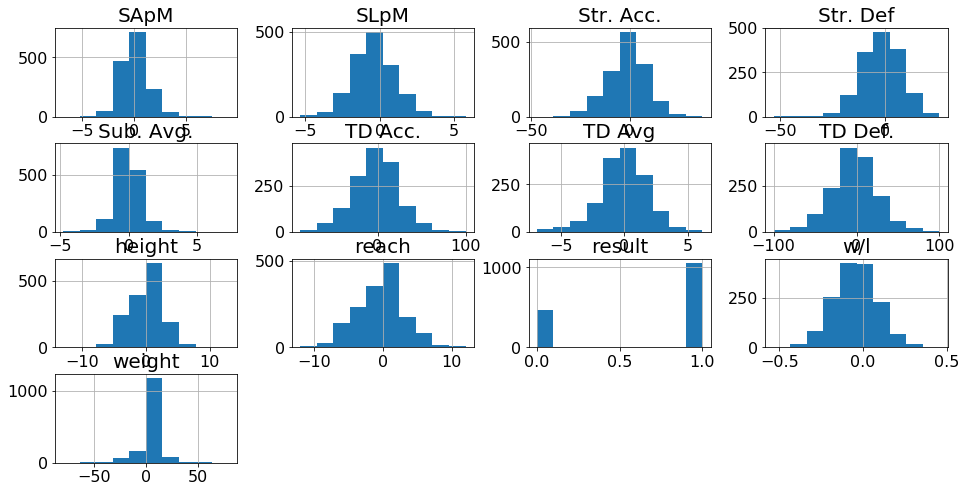

In [146]:
_ = df_deltas_top15.hist()

In [148]:
df_5w[(df_5w['first'] == 'Georges') ]

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
2416,Georges,St-Pierre,Rush,"5' 11""",170 lbs.,"76.0""",Orthodox,25,2,0,NaN,3.77,53%,1.38,72%,4.2,74%,83%,1.1


In [23]:
model = clf.fit(X, y)

In [24]:
#try a prediction
conor_stats = df_5w[(df_5w['first'] == 'Conor') & (df_5w['last'] == 'McGregor')]
nate_stats = df_5w[(df_5w['first'] == 'Khabib') & (df_5w['last'] == 'Nurmagomedov')]
conor_stats.loc[:,'result'] = 'n/a'
nate_stats.loc[:,'result'] = 'n/a'
try_delta = generate_delta(conor_stats, nate_stats).iloc[:,:-1].values
model.predict(try_delta)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.])

## All bouts model

In [25]:
df_full = pd.read_csv('./data/full_results.csv', delimiter=',', header=None)
df_full.columns = ['red', 'blue', 'result']
df_full['red_first'] = df_full['red'].str.split(' ', expand=True)[0]
def get_last_name(x):
    return x.split(' ')[-1]
df_full['red_last'] = df_full['red'].apply(get_last_name)
df_full['blue_first'] = df_full['blue'].str.split(' ', expand=True)[0]
df_full['blue_last'] = df_full['blue'].apply(get_last_name)

In [26]:
full_list = df_full['red'].unique()
df_full.head()

,red,blue,result,red_first,red_last,blue_first,blue_last
0,Tom Aaron,Matt Ricehouse,loss,Tom,Aaron,Matt,Ricehouse
1,Tom Aaron,Eric Steenberg,win,Tom,Aaron,Eric,Steenberg
2,Danny Abbadi,Jorge Gurgel,loss,Danny,Abbadi,Jorge,Gurgel
3,Danny Abbadi,Kalib Starnes,loss,Danny,Abbadi,Kalib,Starnes
4,David Abbott,Kevin Ferguson,loss,David,Abbott,Kevin,Ferguson


In [27]:
'''
To generate deltas, loop through the top fighters one by one and concatenate deltas results
'''
frames = []
for fighter in full_list:
    try:
        df_fighter = df_full[df_full['red'] == fighter]
        first = df_fighter['red_first'].values[0]
        last = df_fighter['red_last'].values[0]
        fighter_stats = df_5w[(df_5w['first'] == first) & (df_5w['last'] == last)]
        fighter_stats.isnull().values.any()
        fighter_stats['result'] = 'n/a'
        opponent_stats = pd.merge(df_5w, df_fighter, left_on=['first', 'last'], right_on=['blue_first', 'blue_last'], how='inner')
        fighter_deltas = generate_delta(fighter_stats, opponent_stats)
        frames.append(fighter_deltas)
    except:
        print first, last
#         display(fighter_stats)
#         display(opponent_stats)
# fighter_deltas.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Danny Abbadi
David Abbott
Daniel Acacio
Mike Aina
Hitomi Akano
Razak Al-Hassan
Gilbert Aldana
Kenneth Alexander
Marcio Junior
Olaf Alfonso
Amilcar Alves
Andre Amado
Karl Amoussou
Reese Andy
Shinya Aoki
Erik Apple
Ricardo Arona
Pat Audinwood
Luiz Azeredo
Bryan Baker
Tae Bang
David Baron
Lyle Beerbohm
Charles Bennett
Steve Berger
Bret Bergmark
Keith Berry
Edson Berto
Jason Black
Jesse Bongfeldt
Paul Bradley
Ebenezer Braga
Joe Brammer
Chris Brennan
Aaron Brink
Todd Brown
Steve Bruno
Courtney Buck
Murilo Bustamante
Gina Carano
Phil Cardella
Antonio Junior
Shonie Carter
Bendy Casimir
Luke Caudillo
Ansar Chalangov
Joachim Christensen
Heather Clark
Wayne Cole
Devin Cole
Kit Cope
Muhsin Corbbrey
Wesley Correira
Jeff Cox
Dan Cramer
Alberto Crane
Richard Crunkilton
Marcio Cruz
Philip Fries
Chris Rocha
Mike Torre
Rodrigo Lima
Edilberto Oliveira
Jorge Oliveira
Germaine Randamie
Shane Rosario
Jon Reyes
Thomas Denny
Cory Devela
Edwin DeWees
Alessio Chirico
Rafael Dias
Kyle Dietz
Rafael Anjos
Junior 

In [28]:
df_deltas_full = pd.concat(frames)
df_deltas_full.replace([np.inf, -np.inf], np.nan, inplace=True)
#Need to figure out why there are NAN results
df_deltas_full.dropna(inplace=True)

In [29]:
train_predictors = df_deltas_full.iloc[:,:-1]
train_response = df_deltas_full['result']
X = train_predictors.values
y = train_response.values

In [30]:
print X.shape
print y.shape

(7727, 12)
(7727,)


In [35]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_jobs=-1, max_features=5, n_estimators=500)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
#     print("mislabeled out of %d obs : %0.2f"% (x_test.shape[0], 100*(y_test != y_pred).sum()/float(x_test.shape[0])))
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 32.55
